In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'
image_size = 224

## Experiment 1: Freezing all layers - Same as Transfer Learning
Create the model

In [4]:
#레이어를 얼려서, 전이학습과 똑같이 한다.
from keras.applications import VGG16

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

#학습이 일어나지 않도록 얼린다. 만약 하지 않으면, 인식률은 좋아지겠지만, 오래걸린다.
#모든 레이어에 대하여, False로 둔다.

#나머지부분은 얼리고, 마지막 4개에 대해서만 학습을 시키겠다.
#for layer in vgg_conv.layers[:-4]:
#이런것을 파인튜닝이라고 한다.
#    layer.trainable = False
    
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

#레이어 출력
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

#새로운 레이어만 추가적용
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

<keras.engine.input_layer.InputLayer object at 0x0000027C2E170A48> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2ABB1908> False
<keras.layers.convolutional.Conv2D object at 0x0000027C219E8A48> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027C2E1C43C8> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E1D2A88> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E1D52C8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027C2E1E3208> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E1EDB88> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E1F0148> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E1F7F88> False
<keras.layers.pooling.MaxPooling2D object at 0x0000027C2E20AAC8> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E2163C8> False
<keras.layers.convolutional.Conv2D object at 0x0000027C2E216988>

## Experiment 1
Train the model

In [8]:
# No Data augmentation 
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
#100으로 하면 컴퓨터 터진다.
#결과에 크기는 많이 주지 않고, 연산속도에 영향을 준다.
train_batchsize = 20
val_batchsize = 10

# Data Generator for Training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data Generator for Validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 25,694,211
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/50
30/30 [==============================] - 58s 2s/step - loss: 0.1544 - accuracy: 0.9450 - val_loss: 5.9753e-05 - val_accuracy: 0.8533
Epoch 2/50
30/30 [==============================] - 62s 2s/step - loss: 0.1783 - accuracy: 0.9417 - val_loss: 0.7785 - val_accuracy: 0.8200
Epoch 3/50
30/30 [==============================] - 62s 2s/step - loss: 0.3081 - accuracy: 0.9317 - val_loss: 1.6235e-05 - val_accuracy: 0.7867
Epoch 4/50
30/30 [==============================] - 60s 2s/step - loss: 0.2510 - accuracy: 0.9383 - val_loss: 0.3169 - val_accuracy: 0.8467
Epoch 5/50
30/30 [==============================] - 60s 2s/step - loss: 0.0957 - accuracy: 0.9617 - val_loss: 0.0144 - val_accuracy: 0.8800
Epoch 6/50
30/30 [==============================] - 60s 2s/step - loss: 0.1346 - accuracy: 0.9617 - val_loss: 4.3105e-04 - val_accuracy: 0.9067
Epoch 7/50
30/30 [==============================] - 60s 2s/step - loss: 0.0210 - accuracy: 0.9900 - val_loss: 2.9870e-05 - val_accuracy: 0.8800
Epoc

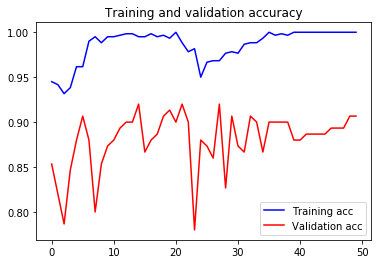

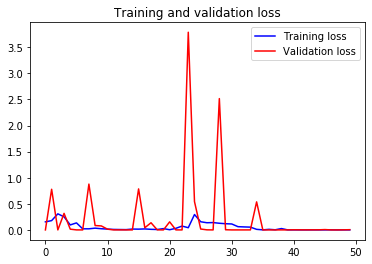

In [11]:
# Save the Model
model.save('all_freezed.h5')

# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()